# Imports

In [24]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Load model and data

In [194]:
class AE(nn.Module):
    def __init__(self, hidden_size=50, act_hist={}, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=hidden_size
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_size, out_features=hidden_size
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=hidden_size, out_features=hidden_size
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_size, out_features=kwargs["input_shape"]
        )
        self.state = {}

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.sigmoid(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.sigmoid(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

    # this method runs on every forward pass if attach_hook if attach_hook is called beforehand
    def get_activation(self, module_name):
        def hook(model, input, output):
            self.state[module_name] = output.detach()
        return hook

    def attach_hooks(self, module_names):
        for name in module_names:
            layer = getattr(self, name)
            layer.register_forward_hook(self.get_activation(name))

FAM = 'f1'
MHLS = 20
CHP = '5000'

# Loader for input data
def get_loader(batch_size):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
    dataset = datasets.ImageFolder(f'monsters/{FAM}', transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = AE(input_shape=64*64, hidden_size=MHLS)
model.load_state_dict(torch.load(f'model_data{MHLS}/{FAM}/checkpoint{CHP}'))
model.eval()
loader = get_loader(1)

# Visualize reconstruction

/var/folders/76/f7mjh1ks5339cvcfyvzxgmy00000gp/T/ipykernel_90342/4026855373.py:67: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  inps = np.array(inps).reshape([6, 6])
/var/folders/76/f7mjh1ks5339cvcfyvzxgmy00000gp/T/ipykernel_90342/4026855373.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inps = np.array(inps).reshape([6, 6])
/var/folders/76/f7mjh1ks5339cvcfyvzx

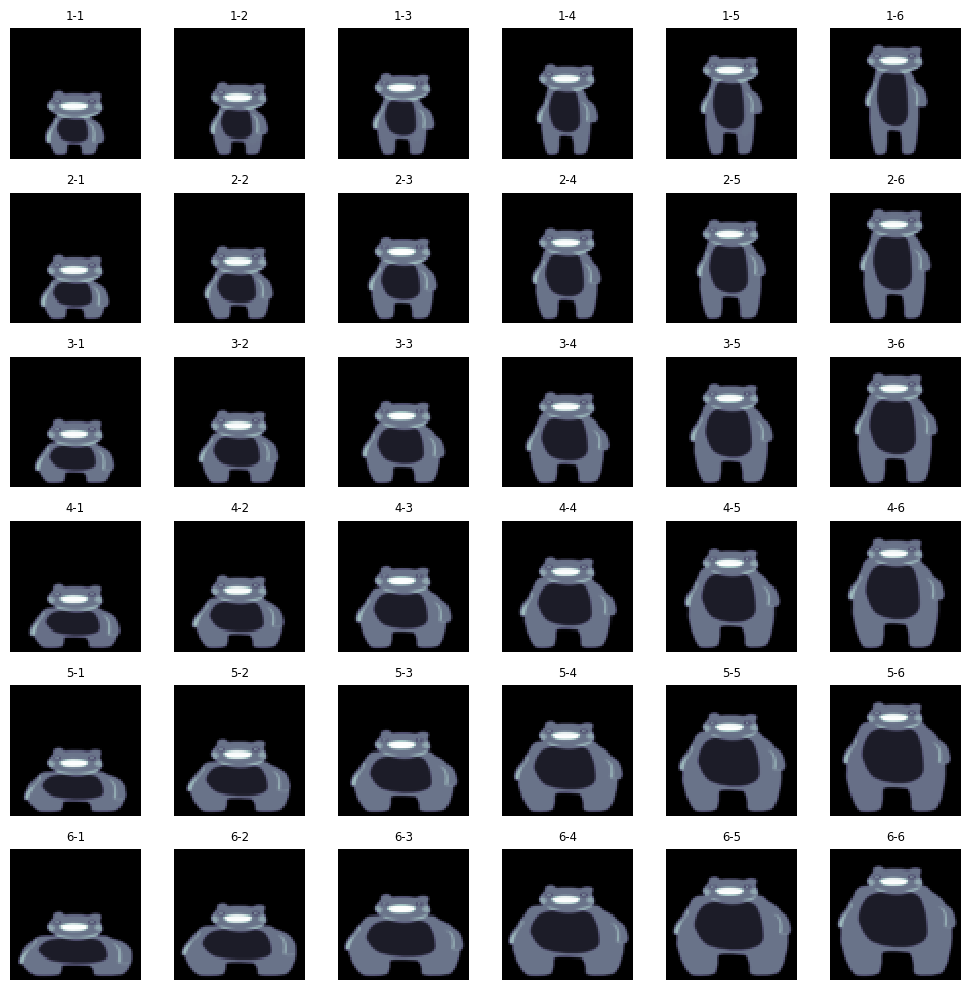

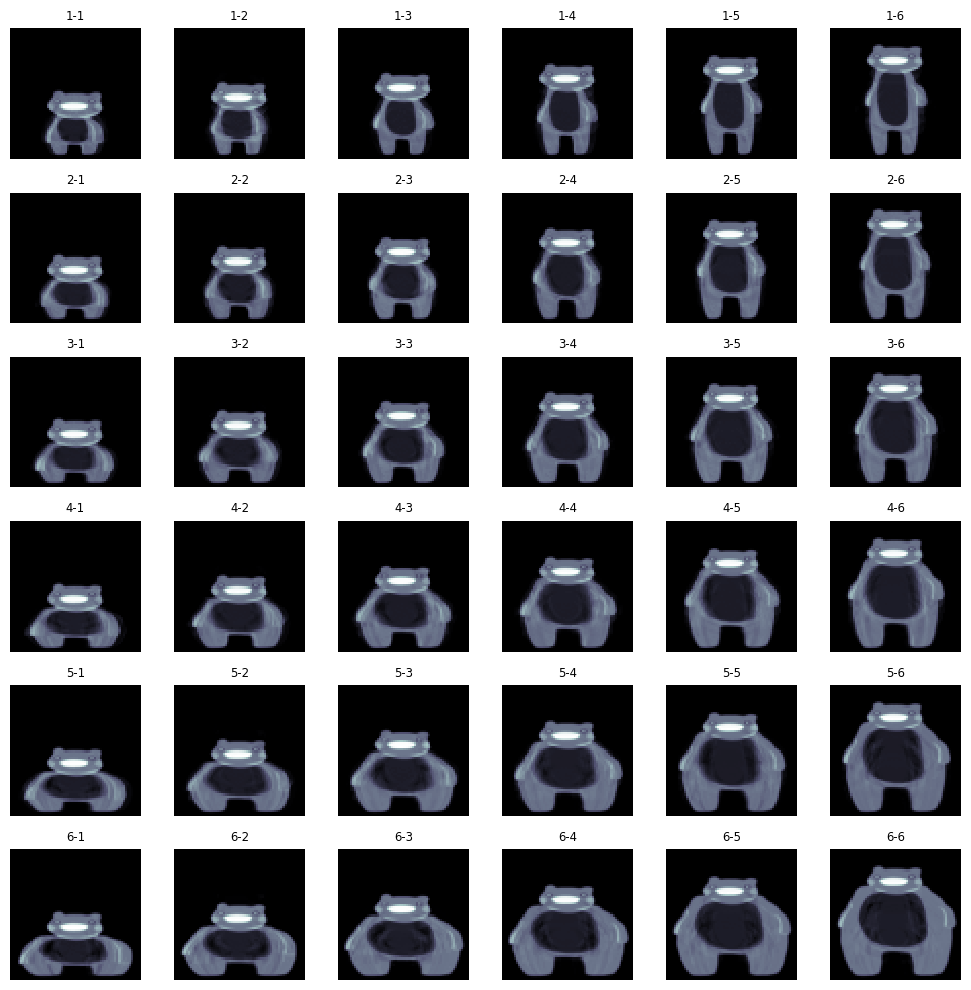

In [195]:
def to_pill(t):
    transform = transforms.ToPILImage()
    return transform(t)


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def mpl_image_grid(imgs, rows, cols):
    assert np.size(imgs) == rows*cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=[10, 10])
    for row in range(rows):
        for col in range(cols):
            ax = axes[row, col]
            ax.imshow(imgs[row, col], cmap='bone', interpolation='none')
            ax.set_axis_off()
            ax.set_title(f'{row+1}-{col+1}', fontsize='small')
    fig.tight_layout()


def side_by_side(imgs, rows, cols):    
    assert np.size(imgs) == rows*cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=[10, 10])
    for row in range(rows):
        for col in range(cols):
            ax = axes[row, col]
            ax.imshow(imgs[row, col], cmap='bone', interpolation='none')
            ax.set_axis_off()
            ax.set_title(f'{row+1}-{col+1}', fontsize='small')
    fig.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.encoder_output_layer.register_forward_hook(get_activation('encoder_output_layer'))

inps = []
reps = []
outs = []
for i, (batch_features, _) in enumerate(loader):
    # Prepare input
    inp = batch_features.view(-1, 64*64).to('cpu')
    inp = inp.reshape(-1, 64*64)

    # Generate output
    out = model(inp)

    # Read representation
    act = activation['encoder_output_layer'].detach().cpu().clone().numpy()  

    reps.append(act)
    inps.append(to_pill(inp.reshape(64, 64)))
    outs.append(to_pill(out.reshape(64, 64)))

inps = np.array(inps).reshape([6, 6])
outs = np.array(outs).reshape([6, 6])
reps = np.array(reps).reshape([6, 6, -1])

mpl_image_grid(inps, 6, 6)
mpl_image_grid(outs, 6, 6)



# Visualize hidden layer activations

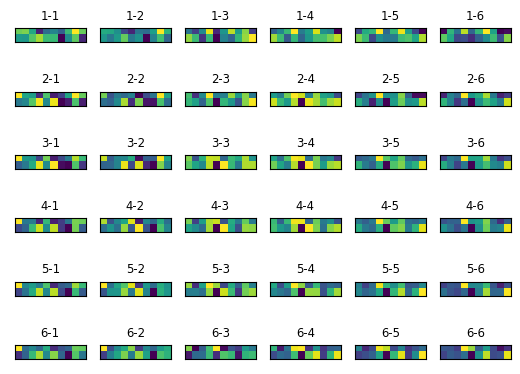

In [196]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

labels, d1, d2 = [], [], []

fig, axs = plt.subplots(6, 6)
for r in range(6):
    for c in range(6):
        d1.append('d1>=3' if r >= 3 else 'd1<=3')
        d2.append('d2>=3' if c >= 3 else 'd2<=3')
        labels.append(f'{r+1}-{c+1}')
        axs[r, c].imshow(reps[r, c, :].reshape([-1, 10]))
        axs[r, c].get_xaxis().set_visible(False)
        axs[r, c].get_yaxis().set_visible(False)
        axs[r, c].set_title(labels[-1], fontsize='small')

# Representational similarity

<Figure size 640x480 with 0 Axes>

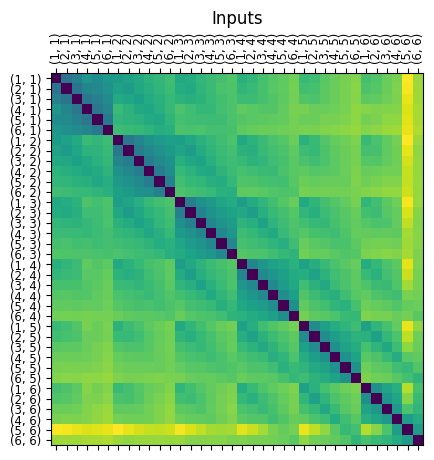

<Figure size 640x480 with 0 Axes>

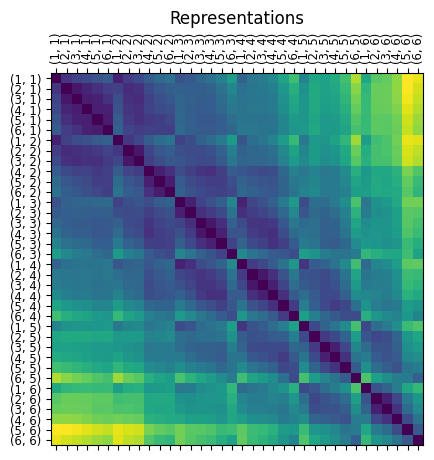

<Figure size 640x480 with 0 Axes>

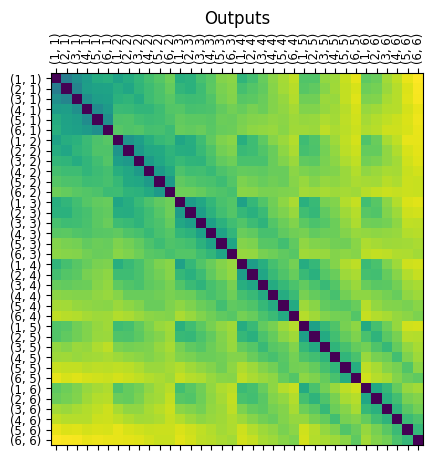

<Figure size 640x480 with 0 Axes>

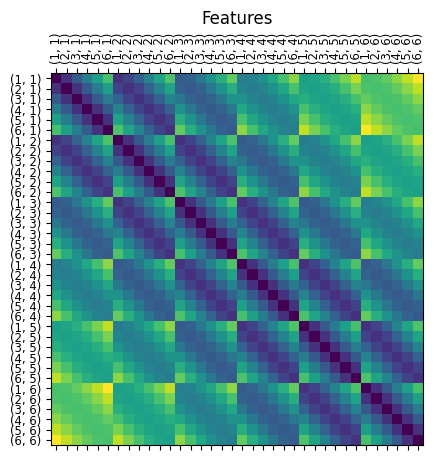

In [205]:
def feature_pairs(a, b=None, t=None):
    x, y = np.meshgrid(np.arange(a), np.arange(a) if b is None else b)
    xy = []
    for xi, yi in zip(x.flatten(), y.flatten()):
        xy.append([xi, yi])
    if t:
        return t(np.stack(xy, axis=0))
    return np.stack(xy, axis=0)

def euclid_grid(d, inds=False):
    m = np.zeros([36, 36])
    for i, (d1i, d2i) in enumerate(feature_pairs(6)):
        for j, (d1j, d2j) in enumerate(feature_pairs(6)):
            a, b = np.array(d[d1i, d2i]), np.array(d[d1j, d2j])
            diff = a.flatten().squeeze() - b.flatten().squeeze()
            if inds: 
                diff = np.array([d1i, d2i]) - np.array([d1j, d2j])
            m[i, j] = np.sqrt(np.sum(np.square(diff)))
    return m


def plot_fig(title, grid):
    plt.figure(title)
    plt.matshow(grid, cmap='viridis')
    plt.title(title)
    ax = plt.gca()
    ticks = np.arange(npairs)
    ticklabels = [f'({x+1}, {y+1})' for (x, y) in pairs]
    _ = plt.xticks(ticks)
    _ = plt.yticks(ticks)
    _ = plt.gca().set_xticklabels(ticklabels, rotation=90, fontsize='small')
    _ = plt.gca().set_yticklabels(ticklabels, fontsize='small')


pairs = feature_pairs(6)
npairs = len(pairs)

plot_fig('Inputs', euclid_grid(inps))
plot_fig('Representations', euclid_grid(reps))
plot_fig('Outputs', euclid_grid(outs))
plot_fig('Features', euclid_grid(inps, inds=True))

# PCA

Variance explained


PC1      0.687790
PC2      0.215453
Total    0.903242
dtype: float32

,PC1,PC2,label,d1,d2,featurVals
0,-28.024492,9.100818,1-1,d1<=3,d2<=3,"[1, 1]"
1,-24.818762,11.204792,1-2,d1<=3,d2<=3,"[1, 2]"
2,-10.785250,11.650476,1-3,d1<=3,d2<=3,"[1, 3]"
3,-6.619648,13.709453,1-4,d1<=3,d2>=3,"[1, 4]"
4,1.627952,20.661541,1-5,d1<=3,d2>=3,"[1, 5]"


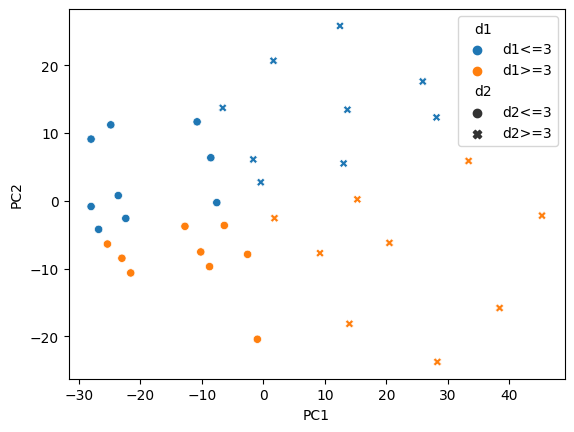

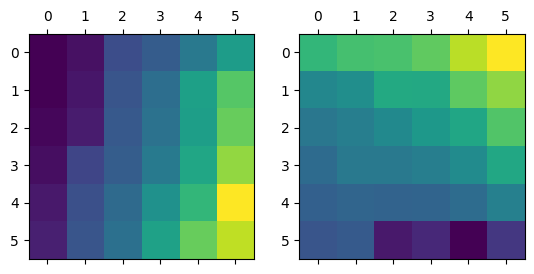

In [200]:
n = 2

d = reps.reshape([36, 20]).squeeze()
# print(d)
d.shape
pca = PCA(n_components=n)
pca_data = pca.fit_transform(d)
print('Variance explained')
display(pd.Series(dict(
    PC1 = pca.explained_variance_ratio_[0],
    PC2 = pca.explained_variance_ratio_[1],
    Total = pca.explained_variance_ratio_.sum()
)))

pcadf = pd.DataFrame(data = pca_data, columns = [f'PC{i+1}' for i in range(n)])
pcadf['label'] = labels
pcadf['d1'] = d1
pcadf['d2'] = d2
pcadf['featurVals'] = pcadf.label.str.split('-')
display(pcadf.head())

sns.scatterplot(data=pcadf, x='PC1', y='PC2', hue='d1', style='d2')

m1, m2 = np.zeros([6, 6]), np.zeros([6, 6])
m3 = np.zeros([6, 6])
for i, row in pcadf.iterrows():
    i, j = [int(v)-1 for v in row.featurVals]
    m1[i, j] = row.PC1
    m2[i, j] = row.PC2

fig, axes = plt.subplots(nrows=1, ncols=n)
axes[0].matshow(m1)
axes[1].matshow(m2)


# Learning food preference from features

In [207]:
import numpy as np
# np.seterr(over='ignore')

class NeuralNetwork():
    def __init__(self):
        np.random.seed(1)  # Seed the random number generator
        self.weights = {}  # Create dict to hold weights
        self.num_layers = 1  # Set initial number of layer to one (input layer)
        self.adjustments = {}  # Create dict to hold adjustements

    def add_layer(self, shape):
        # Create weights with shape specified + biases
        self.weights[self.num_layers] = np.vstack((2 * np.random.random(shape) - 1, 2 * np.random.random((1, shape[1])) - 1))
        # Initialize the adjustements for these weights to zero
        self.adjustments[self.num_layers] = np.zeros(shape)
        self.num_layers += 1

    def __sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def __sigmoid_derivative(self, x):
        return x * (1 - x)

    def predict(self, data):
        # Pass data through pretrained network
        for layer in range(1, self.num_layers+1):
            data = np.dot(data, self.weights[layer-1][:, :-1]) + self.weights[layer-1][:, -1] # + self.biases[layer]
            data = self.__sigmoid(data)
        return data

    def __forward_propagate(self, data):
        # Progapagate through network and hold values for use in back-propagation
        activation_values = {}
        activation_values[1] = data
        for layer in range(2, self.num_layers+1):
            data = np.dot(data.T, self.weights[layer-1][:-1, :]) + self.weights[layer-1][-1, :].T # + self.biases[layer]
            data = self.__sigmoid(data).T
            activation_values[layer] = data
        return activation_values

    def simple_error(self, outputs, targets):
        return targets - outputs

    def sum_squared_error(self, outputs, targets):
        return 0.5 * np.mean(np.sum(np.power(outputs - targets, 2), axis=1))

    def __back_propagate(self, output, target):
        deltas = {}
        # Delta of output Layer
        deltas[self.num_layers] = output[self.num_layers] - target

        # Delta of hidden Layers
        for layer in reversed(range(2, self.num_layers)):  # All layers except input/output
            a_val = output[layer]
            weights = self.weights[layer][:-1, :]
            prev_deltas = deltas[layer+1]
            deltas[layer] = np.multiply(np.dot(weights, prev_deltas), self.__sigmoid_derivative(a_val))

        # Caclculate total adjustements based on deltas
        for layer in range(1, self.num_layers):
            self.adjustments[layer] += np.dot(deltas[layer+1], output[layer].T).T

    def __gradient_descente(self, batch_size, learning_rate):
        # Calculate partial derivative and take a step in that direction
        for layer in range(1, self.num_layers):
            partial_d = (1/batch_size) * self.adjustments[layer]
            self.weights[layer][:-1, :] += learning_rate * -partial_d
            self.weights[layer][-1, :] += learning_rate*1e-3 * -partial_d[-1, :]


    def train(self, inputs, targets, num_epochs, learning_rate=1, stop_accuracy=1e-5):
        error = []
        for iteration in range(num_epochs):
            for i in range(len(inputs)):
                x = inputs[i]
                y = targets[i]
                # Pass the training set through our neural network
                output = self.__forward_propagate(x)

                # Calculate the error
                loss = self.sum_squared_error(output[self.num_layers], y)
                error.append(loss)

                # Calculate Adjustements
                self.__back_propagate(output, y)

            self.__gradient_descente(i, learning_rate)

            # Check if accuarcy criterion is satisfied
            if np.mean(error[-(i+1):]) < stop_accuracy and iteration > 0:
                break

        return(np.asarray(error), iteration+1)


In [208]:
# Create instance of a neural network
nn = NeuralNetwork()

# Add Layers (Input layer is created by default)
nn.add_layer((2, 9))
nn.add_layer((9, 1))

# XOR function
training_data = np.asarray([[0, 0], [0, 1], [1, 0], [1, 1]]).reshape(4, 2, 1)
training_labels = np.asarray([[0], [1], [1], [0]])

error, iteration = nn.train(training_data, training_labels, 5000)
print('Error = ', np.mean(error[-4:]))
print('Epoches needed to train = ', iteration)

Error =  7.299670911230186e-06
Epoches needed to train =  62


In [210]:
reps.reshape([36, 20]).squeeze()

(6, 6, 20)